In [10]:
import matplotlib.pyplot as plt
import numpy as np
from mesh_3d_generator import build_matrix
from svd_compression import compress_matrix, compress
from Tree import Tree, Node, Leaf, InternalNode

In [52]:
from copy import deepcopy

def random_vector(length):
    return np.random.random(length)

def add(node1, node2, max_rank, length):
    if isinstance(node1, Leaf) and node1.zeros:
        return deepcopy(node2)
    elif isinstance(node2, Leaf) and node2.zeros:
        return deepcopy(node1)
    elif isinstance(node1, Leaf) and isinstance(node2, Leaf):
        return compress(node1.U @ node1.V + node2.U @ node2.V, 0, max_rank, length)
    elif isinstance(node1, InternalNode) and isinstance(node2, InternalNode):
        length //= 2
        return InternalNode(
            left_up=add(node1.left_up, node2.left_up, max_rank, length),
            right_up=add(node1.right_up, node2.right_up, max_rank, length),
            left_low=add(node1.left_low, node2.left_low, max_rank, length),
            right_low=add(node1.right_low, node2.right_low, max_rank, length)
        )
    else:
        length //= 2
        if isinstance(node1, InternalNode):
            node1, node2 = node2, node1

        U, V = node1.U, node1.V
        return InternalNode(
            left_up=add(Leaf(U=U[:length], V=V[:, :length]), node2.left_up, max_rank, length),
            right_up=add(Leaf(U=U[:length], V=V[:, length:]), node2.right_up, max_rank, length),
            left_low=add(Leaf(U=U[length:], V=V[:, :length]), node2.left_low, max_rank, length),
            right_low=add(Leaf(U=U[length:], V=V[:, length:]), node2.right_low, max_rank, length)
        )


def mul(node1, node2, max_rank, length):
    if (isinstance(node1, Leaf) and node1.zeros) or (isinstance(node2, Leaf) and node2.zeros):
        return Leaf(zeros=True)
    elif isinstance(node1, Leaf) and isinstance(node2, Leaf):
        return Leaf(U=node1.U @ np.dot(node1.V, node2.U), V=node2.V)

    length //= 2
    if isinstance(node1, Leaf):
        U, V = node1.U, node1.V
        node1.left_up = Leaf(U=U[:length], V=V[:, :length])
        node1.right_up = Leaf(U=U[:length], V=V[:, length:])
        node1.left_low = Leaf(U=U[length:], V=V[:, :length])
        node1.right_low = Leaf(U=U[length:], V=V[:, length:])

    elif isinstance(node2, Leaf):
        U, V = node2.U, node2.V
        node2.left_up = Leaf(U=U[:length], V=V[:, :length])
        node2.right_up = Leaf(U=U[:length], V=V[:, length:])
        node2.left_low = Leaf(U=U[length:], V=V[:, :length])
        node2.right_low = Leaf(U=U[length:], V=V[:, length:])

    return InternalNode(
        left_up=add(mul(node1.left_up, node2.left_up, max_rank, length),
                    mul(node1.right_up, node2.left_low, max_rank, length), max_rank, length),
        right_up=add(mul(node1.left_up, node2.right_up, max_rank, length),
                    mul(node1.right_up, node2.right_low, max_rank, length), max_rank, length),
        left_low=add(mul(node1.left_low, node2.left_up, max_rank, length),
                    mul(node1.right_low, node2.left_low, max_rank, length), max_rank, length),
        right_low=add(mul(node1.left_low, node2.right_up, max_rank, length),
                    mul(node1.right_low, node2.right_low, max_rank, length), max_rank, length)
    )



def add_matrices(h_mat1, h_mat2):
    if h_mat1.length != h_mat2.length:
        raise ValueError("Matrices should have the same dimensions in order to add them")
    max_rank = min(h_mat1.max_rank, h_mat2.max_rank)
    root = add(h_mat1.root, h_mat2.root, max_rank, h_mat1.length)
    return Tree(h_mat1.length, max_rank, root)

def multiply_matrices(h_mat1, h_mat2):
    if h_mat1.length != h_mat2.length:
        raise ValueError("Matrices should have the same dimensions in order to multiply them")
    max_rank = min(h_mat1.max_rank, h_mat2.max_rank)
    root = mul(h_mat1.root, h_mat2.root, max_rank, h_mat1.length)
    return Tree(h_mat1.length, max_rank, root)


In [53]:
mat = build_matrix(2)
mat2 = build_matrix(2)
vec = random_vector(64)
compressed = compress_matrix(mat, 0, 10)
compressed2 = compress_matrix(mat2, 0, 10)

In [54]:
tak = multiply_matrices(compressed, compressed2)

In [55]:
res = compressed.multiply_by_vector(vec)

In [56]:
print(np.allclose(res, mat @ vec))

True


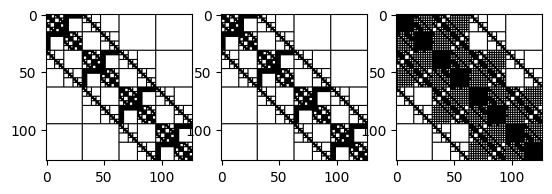

In [57]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(compressed.draw(), cmap='gray')
ax[1].imshow(compressed2.draw(), cmap='gray')
ax[2].imshow(tak.draw(), cmap='gray');

In [58]:
deconstruct = tak.eval()

In [59]:
print(np.allclose(deconstruct, (mat @ mat2)))

True
